<a href="https://colab.research.google.com/github/ehsankarami1358/LOKA_HYDRO/blob/main/LOKA_2026_Hill_chart_u2_r5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, RBFInterpolator
from scipy.ndimage import gaussian_filter
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')


In [20]:
# ============================================
# 1. LOAD AND PREPARE DATA
# ============================================

print("="*60)
print("HILL CHART ANALYSIS - UNIT 2")
print("="*60)

# Load your CSV file
df = pd.read_csv("u2_MW_OP_FL_L_1_1_2026_11_2_2026_R3.csv")

# Convert timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculate Net Head
df['Net_Head'] = df['HEAD_L(m)'] - df['TAIL_L(m)']

# Rename columns for easier use
df.rename(columns={
    'ACTIVE_POWER(MW)': 'Power',
    'OPPENING(%)': 'Opening',
    'FLOW(m3/s)': 'Flow',
    'SPEED(RPM)': 'Speed',
    }, inplace=True)

# Calculate efficiency
df['Efficiency'] = (df['Power'] * 1000) / (9.81 * df['Flow'] * df['Net_Head'])

# Filter for operational data (remove shutdowns)
df_operational = df[
    (df['Power'] > 1.0) &
    (df['Flow'] > 1.0) &
    (df['Efficiency'] > 0.70) &
    (df['Efficiency'] < 0.98)
].copy()

# Deduct 3.63 from every value in the 'Flow' column
df_operational['Flow'] = df_operational['Flow']

# Recalculate Efficiency after flow adjustment
df_operational['Efficiency'] = (df_operational['Power'] * 1000) / (9.81 * df_operational['Flow'] * df_operational['Net_Head'])

# Filter again based on the new efficiency calculation to ensure valid data
df_operational = df_operational[
    (df_operational['Efficiency'] > 0.70) &
    (df_operational['Efficiency'] < 0.98)
].copy()

print(f"Total data points: {len(df)}")
print(f"Operational points: {len(df_operational)}")
print(f"Date range: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")
print(f"Head range: {df_operational['Net_Head'].min():.1f} - {df_operational['Net_Head'].max():.1f} m")
print(f"Power range: {df_operational['Power'].min():.1f} - {df_operational['Power'].max():.1f} MW")
print(f"Efficiency range: {df_operational['Efficiency'].min():.3f} - {df_operational['Efficiency'].max():.3f}")

HILL CHART ANALYSIS - UNIT 2
Total data points: 804
Operational points: 283
Date range: 2026-01-01 to 2026-02-11
Head range: 76.5 - 86.7 m
Power range: 74.7 - 141.5 MW
Efficiency range: 0.813 - 0.926


In [21]:
# ============================================
# 2. TURBINE PARAMETERS
# ============================================

# Your turbine specifications
DESIGN_HEAD = 89.5      # meters
RUNNER_DIAMETER = 4.2   # meters
RUNNER_AREA = RUNNER_DIAMETER ** 2

print(f"\nTurbine Parameters:")
print(f"Design Head: {DESIGN_HEAD} m")
print(f"Runner Diameter: {RUNNER_DIAMETER} m")
print(f"Runner Area (D²): {RUNNER_AREA:.2f} m²")

# ============================================
# 3. CALCULATE HILL CHART PARAMETERS
# ============================================

print("\n" + "="*60)
print("CALCULATING HILL CHART PARAMETERS")
print("="*60)

# Calculate unit parameters
df_operational['sqrt_H'] = np.sqrt(df_operational['Net_Head'])
df_operational['H_32'] = df_operational['Net_Head'] ** 1.5

# Unit discharge: Q11 = Q / (D² * √H)
df_operational['Q11'] = df_operational['Flow'] / (RUNNER_AREA * df_operational['sqrt_H'])

# Unit power: P11 = P / (D² * H^(3/2))
df_operational['P11'] = df_operational['Power'] / (RUNNER_AREA * df_operational['H_32'])

# Relative unit speed (since speed is constant): n11_rel = 1/√H
df_operational['n11_rel'] = 1 / df_operational['sqrt_H']

# Normalize to design head
sqrt_H_design = np.sqrt(DESIGN_HEAD)
df_operational['n11_norm'] = df_operational['n11_rel'] * sqrt_H_design

# Specific energy (kWh per m³ of water)
df_operational['Specific_Energy'] = df_operational['Power'] * 1000 / df_operational['Flow']

print(f"Q11 range: {df_operational['Q11'].min():.3f} to {df_operational['Q11'].max():.3f}")
print(f"P11 range: {df_operational['P11'].min():.4f} to {df_operational['P11'].max():.4f}")
print(f"Average efficiency: {df_operational['Efficiency'].mean():.3f}")
print(f"Average specific energy: {df_operational['Specific_Energy'].mean():.2f} kWh/m³")


Turbine Parameters:
Design Head: 89.5 m
Runner Diameter: 4.2 m
Runner Area (D²): 17.64 m²

CALCULATING HILL CHART PARAMETERS
Q11 range: 0.707 to 1.218
P11 range: 0.0058 to 0.0107
Average efficiency: 0.896
Average specific energy: 734.92 kWh/m³


In [22]:
df_operational['Opening'].mean()

np.float64(66.5293760777385)

In [23]:
# ============================================
# 4. FIND BEST EFFICIENCY POINT (BEP)
# ============================================

bep_idx = df_operational['Efficiency'].idxmax()
bep_data = df_operational.loc[bep_idx]

print("\n" + "="*60)
print("BEST EFFICIENCY POINT (BEP)")
print("="*60)
print(f"Efficiency: {bep_data['Efficiency']:.4f}")
print(f"Opening: {bep_data['Opening']:.1f}%")
print(f"Power: {bep_data['Power']:.2f} MW")
print(f"Head: {bep_data['Net_Head']:.2f} m")
print(f"Flow: {bep_data['Flow']:.2f} m³/s")
print(f"Q11: {bep_data['Q11']:.3f}")
print(f"P11: {bep_data['P11']:.4f}")
print(f"Specific Energy: {bep_data['Specific_Energy']:.2f} kWh/m³")


BEST EFFICIENCY POINT (BEP)
Efficiency: 0.9261
Opening: 75.9%
Power: 136.10 MW
Head: 85.75 m
Flow: 174.71 m³/s
Q11: 1.070
P11: 0.0097
Specific Energy: 779.05 kWh/m³



CREATING HILL CHART VISUALIZATIONS


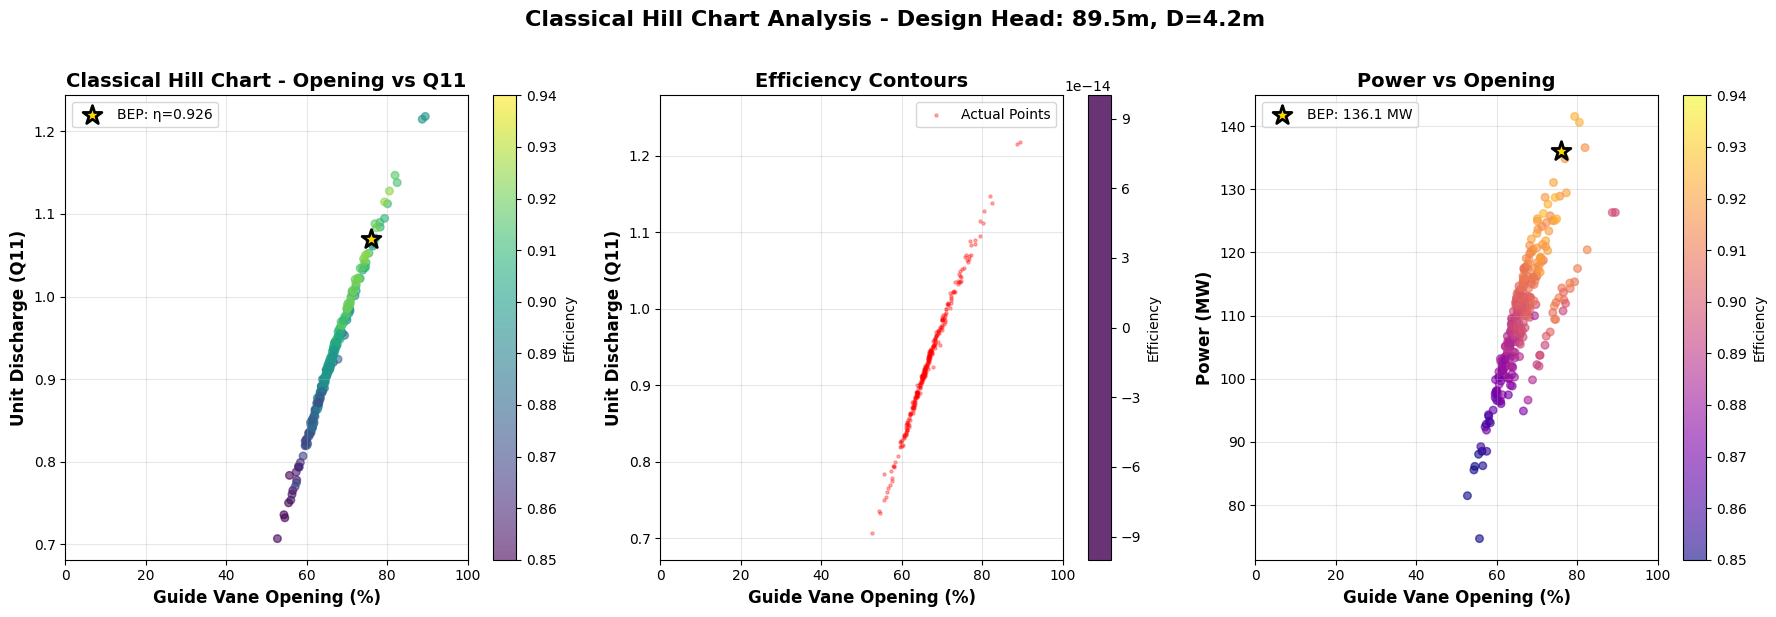

In [24]:
# ============================================
# 5. CREATE CLASSICAL HILL CHART
# ============================================

print("\n" + "="*60)
print("CREATING HILL CHART VISUALIZATIONS")
print("="*60)

# Figure 1: Classical Hill Chart (Opening vs Q11)
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1A: Scatter plot
scatter1 = axes1[0].scatter(df_operational['Opening'], df_operational['Q11'],
                           c=df_operational['Efficiency'],
                           s=30, alpha=0.6, cmap='viridis',
                           vmin=0.85, vmax=0.94)

axes1[0].scatter(bep_data['Opening'], bep_data['Q11'],
                s=200, marker='*', color='gold',
                edgecolor='black', linewidth=2,
                label=f'BEP: η={bep_data["Efficiency"]:.3f}')

axes1[0].set_xlabel('Guide Vane Opening (%)', fontsize=12, fontweight='bold')
axes1[0].set_ylabel('Unit Discharge (Q11)', fontsize=12, fontweight='bold')
axes1[0].set_title('Classical Hill Chart - Opening vs Q11', fontsize=14, fontweight='bold')
axes1[0].grid(True, alpha=0.3)
axes1[0].set_xlim(0, 100)
axes1[0].legend()
plt.colorbar(scatter1, ax=axes1[0], label='Efficiency')
# Plot 1B: Contour plot
# Create grid for interpolation
opening_grid = np.linspace(0, 100, 80)
q11_grid = np.linspace(df_operational['Q11'].min() * 0.95,
                       df_operational['Q11'].max() * 1.05, 80)
opening_mesh, q11_mesh = np.meshgrid(opening_grid, q11_grid)

# Interpolate efficiency values
points = df_operational[['Opening', 'Q11']].values
values = df_operational['Efficiency'].values
efficiency_grid = griddata(points, values, (opening_mesh, q11_mesh),
                          method='cubic', fill_value=np.nan)

# Smooth the grid
if not np.all(np.isnan(efficiency_grid)):
    efficiency_grid = gaussian_filter(efficiency_grid, sigma=1.0)

# Plot contours
contour = axes1[1].contourf(opening_mesh, q11_mesh, efficiency_grid,
                          levels=20, cmap='viridis', alpha=0.8,
                          vmin=0.85, vmax=0.94)

# Add contour lines
CS = axes1[1].contour(opening_mesh, q11_mesh, efficiency_grid,
                     levels=10, colors='black', linewidths=0.5, alpha=0.5)
axes1[1].clabel(CS, inline=True, fontsize=8, fmt='%1.3f')

# Mark BEP on contour
if not np.all(np.isnan(efficiency_grid)):
    bep_grid_idx = np.unravel_index(np.nanargmax(efficiency_grid),
                                   efficiency_grid.shape)
    axes1[1].scatter(opening_mesh[bep_grid_idx], q11_mesh[bep_grid_idx],
                    s=200, marker='*', color='gold',
                    edgecolor='black', linewidth=2,
                    label=f'Grid BEP: η={efficiency_grid[bep_grid_idx]:.3f}')

axes1[1].scatter(df_operational['Opening'], df_operational['Q11'],
                s=5, color='red', alpha=0.3, label='Actual Points')

axes1[1].set_xlabel('Guide Vane Opening (%)', fontsize=12, fontweight='bold')
axes1[1].set_ylabel('Unit Discharge (Q11)', fontsize=12, fontweight='bold')
axes1[1].set_title('Efficiency Contours', fontsize=14, fontweight='bold')
axes1[1].grid(True, alpha=0.3)
axes1[1].set_xlim(0, 100)
axes1[1].legend()
plt.colorbar(contour, ax=axes1[1], label='Efficiency')

# Plot 1C: Power vs Opening
scatter3 = axes1[2].scatter(df_operational['Opening'], df_operational['Power'],
                           c=df_operational['Efficiency'],
                           s=30, alpha=0.6, cmap='plasma',
                           vmin=0.85, vmax=0.94)

axes1[2].scatter(bep_data['Opening'], bep_data['Power'],
                s=200, marker='*', color='gold',
                edgecolor='black', linewidth=2,
                label=f'BEP: {bep_data["Power"]:.1f} MW')

axes1[2].set_xlabel('Guide Vane Opening (%)', fontsize=12, fontweight='bold')
axes1[2].set_ylabel('Power (MW)', fontsize=12, fontweight='bold')
axes1[2].set_title('Power vs Opening', fontsize=14, fontweight='bold')
axes1[2].grid(True, alpha=0.3)
axes1[2].set_xlim(0, 100)
axes1[2].legend()
plt.colorbar(scatter3, ax=axes1[2], label='Efficiency')

plt.suptitle(f'Classical Hill Chart Analysis - Design Head: {DESIGN_HEAD}m, D={RUNNER_DIAMETER}m',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig1.savefig('hill_chart_classical.png', dpi=300, bbox_inches='tight')

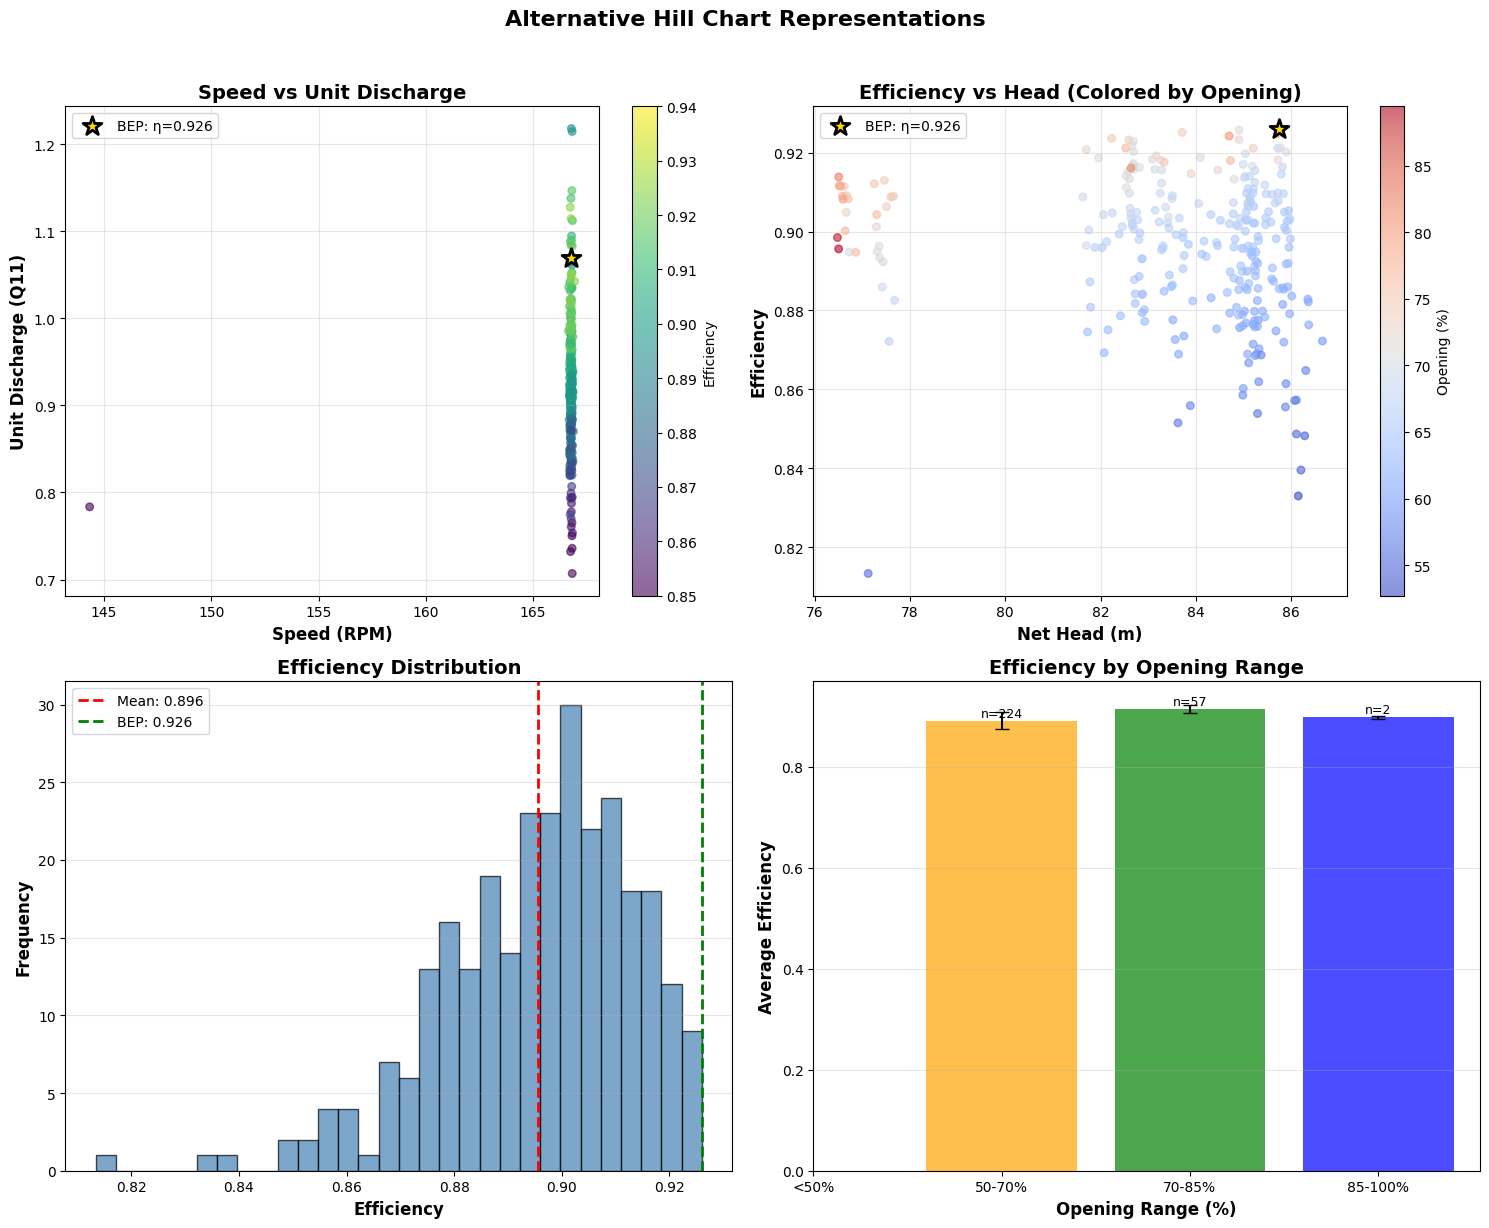

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, RBFInterpolator
from scipy.ndimage import gaussian_filter
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 6. ALTERNATIVE HILL CHART REPRESENTATIONS
# ============================================

fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))

# Plot 2A: Speed vs Q11
scatter2a = axes2[0, 0].scatter(df_operational['Speed'], df_operational['Q11'],
                               c=df_operational['Efficiency'],
                               s=30, alpha=0.6, cmap='viridis',
                               vmin=0.85, vmax=0.94)

axes2[0, 0].scatter(df_operational.loc[bep_idx, 'Speed'],
                   df_operational.loc[bep_idx, 'Q11'],
                   s=200, marker='*', color='gold',
                   edgecolor='black', linewidth=2,
                   label=f'BEP: η={bep_data["Efficiency"]:.3f}')

axes2[0, 0].set_xlabel('Speed (RPM)', fontsize=12, fontweight='bold')
axes2[0, 0].set_ylabel('Unit Discharge (Q11)', fontsize=12, fontweight='bold')
axes2[0, 0].set_title('Speed vs Unit Discharge', fontsize=14, fontweight='bold')
axes2[0, 0].grid(True, alpha=0.3)
axes2[0, 0].legend()
plt.colorbar(scatter2a, ax=axes2[0, 0], label='Efficiency')

# Plot 2B: Efficiency vs Head colored by Opening
scatter2b = axes2[0, 1].scatter(df_operational['Net_Head'], df_operational['Efficiency'],
                               c=df_operational['Opening'],
                               s=30, alpha=0.6, cmap='coolwarm')

axes2[0, 1].scatter(bep_data['Net_Head'], bep_data['Efficiency'],
                   s=200, marker='*', color='gold',
                   edgecolor='black', linewidth=2,
                   label=f'BEP: η={bep_data["Efficiency"]:.3f}')

axes2[0, 1].set_xlabel('Net Head (m)', fontsize=12, fontweight='bold')
axes2[0, 1].set_ylabel('Efficiency', fontsize=12, fontweight='bold')
axes2[0, 1].set_title('Efficiency vs Head (Colored by Opening)', fontsize=14, fontweight='bold')
axes2[0, 1].grid(True, alpha=0.3)
axes2[0, 1].legend()
plt.colorbar(scatter2b, ax=axes2[0, 1], label='Opening (%)')

# Plot 2C: Efficiency histogram
axes2[1, 0].hist(df_operational['Efficiency'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes2[1, 0].axvline(df_operational['Efficiency'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {df_operational["Efficiency"].mean():.3f}')
axes2[1, 0].axvline(bep_data['Efficiency'], color='green', linestyle='--', linewidth=2,
                   label=f'BEP: {bep_data["Efficiency"]:.3f}')
axes2[1, 0].set_xlabel('Efficiency', fontsize=12, fontweight='bold')
axes2[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes2[1, 0].set_title('Efficiency Distribution', fontsize=14, fontweight='bold')
axes2[1, 0].grid(True, alpha=0.3, axis='y')
axes2[1, 0].legend()

# Plot 2D: Efficiency by Opening Range
# Create opening bins
opening_bins = [0, 50, 70, 85, 100]
opening_labels = ['<50%', '50-70%', '70-85%', '85-100%']
df_operational['Opening_Bin'] = pd.cut(df_operational['Opening'], bins=opening_bins, labels=opening_labels)

# Calculate average efficiency per bin
efficiency_by_opening = df_operational.groupby('Opening_Bin')['Efficiency'].agg(['mean', 'std', 'count'])

# Bar plot
x_pos = np.arange(len(efficiency_by_opening))
bars = axes2[1, 1].bar(x_pos, efficiency_by_opening['mean'],
                      yerr=efficiency_by_opening['std'],
                      capsize=5, alpha=0.7, color=['red', 'orange', 'green', 'blue'])

axes2[1, 1].set_xlabel('Opening Range (%)', fontsize=12, fontweight='bold')
axes2[1, 1].set_ylabel('Average Efficiency', fontsize=12, fontweight='bold')
axes2[1, 1].set_title('Efficiency by Opening Range', fontsize=14, fontweight='bold')
axes2[1, 1].set_xticks(x_pos)
axes2[1, 1].set_xticklabels(opening_labels)
axes2[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, count in zip(bars, efficiency_by_opening['count']):
    height = bar.get_height()
    axes2[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'n={count}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Alternative Hill Chart Representations', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig2.savefig('hill_chart_alternative.png', dpi=300, bbox_inches='tight')

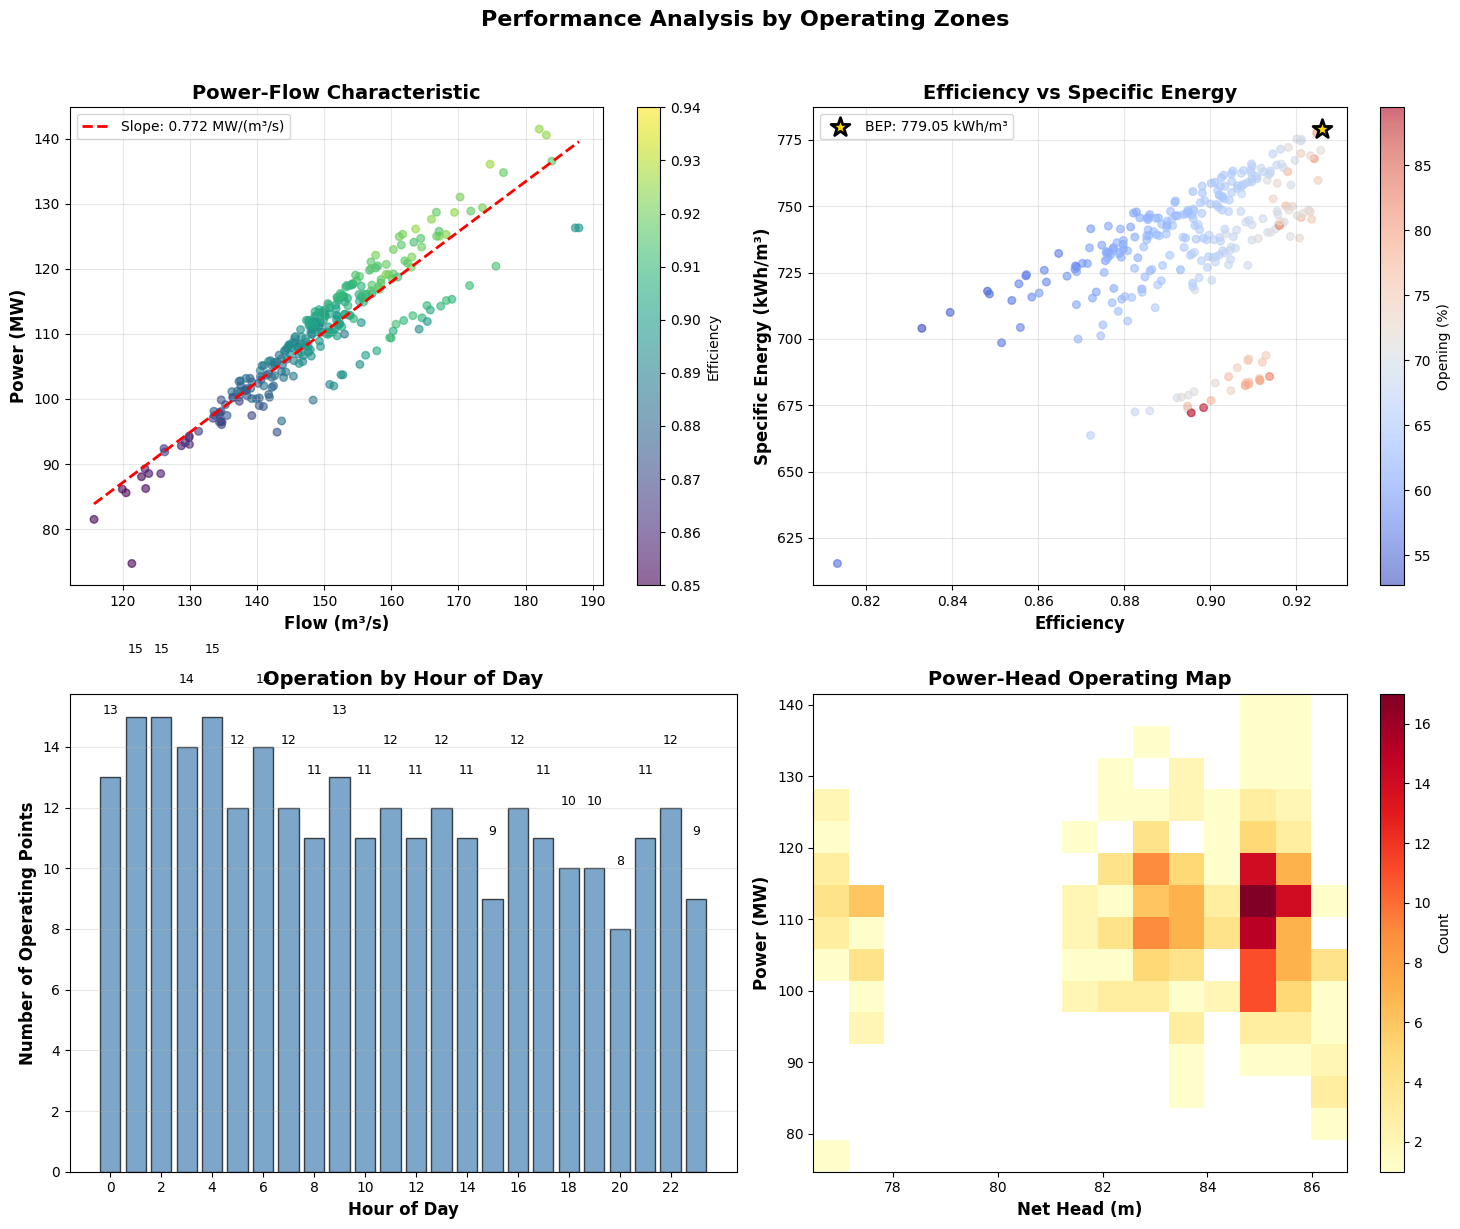

In [26]:
# ============================================
# 7. PERFORMANCE ANALYSIS BY OPERATING ZONES
# ============================================

fig3, axes3 = plt.subplots(2, 2, figsize=(15, 12))

# Plot 3A: Power-Flow characteristic
scatter3a = axes3[0, 0].scatter(df_operational['Flow'], df_operational['Power'],
                               c=df_operational['Efficiency'],
                               s=30, alpha=0.6, cmap='viridis',
                               vmin=0.85, vmax=0.94)

# Add trend line
z = np.polyfit(df_operational['Flow'], df_operational['Power'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_operational['Flow'].min(), df_operational['Flow'].max(), 100)
axes3[0, 0].plot(x_range, p(x_range), 'r--', linewidth=2,
                label=f'Slope: {z[0]:.3f} MW/(m³/s)')

axes3[0, 0].set_xlabel('Flow (m³/s)', fontsize=12, fontweight='bold')
axes3[0, 0].set_ylabel('Power (MW)', fontsize=12, fontweight='bold')
axes3[0, 0].set_title('Power-Flow Characteristic', fontsize=14, fontweight='bold')
axes3[0, 0].grid(True, alpha=0.3)
axes3[0, 0].legend()
plt.colorbar(scatter3a, ax=axes3[0, 0], label='Efficiency')

# Plot 3B: Specific Energy vs Efficiency
scatter3b = axes3[0, 1].scatter(df_operational['Efficiency'], df_operational['Specific_Energy'],
                               c=df_operational['Opening'],
                               s=30, alpha=0.6, cmap='coolwarm')

axes3[0, 1].scatter(bep_data['Efficiency'], bep_data['Specific_Energy'],
                   s=200, marker='*', color='gold',
                   edgecolor='black', linewidth=2,
                   label=f'BEP: {bep_data["Specific_Energy"]:.2f} kWh/m³')

axes3[0, 1].set_xlabel('Efficiency', fontsize=12, fontweight='bold')
axes3[0, 1].set_ylabel('Specific Energy (kWh/m³)', fontsize=12, fontweight='bold')
axes3[0, 1].set_title('Efficiency vs Specific Energy', fontsize=14, fontweight='bold')
axes3[0, 1].grid(True, alpha=0.3)
axes3[0, 1].legend()
plt.colorbar(scatter3b, ax=axes3[0, 1], label='Opening (%)')

# Plot 3C: Operating hours distribution
df_operational['Hour'] = df_operational['Timestamp'].dt.hour
hour_counts = df_operational['Hour'].value_counts().sort_index()
bars3c = axes3[1, 0].bar(hour_counts.index, hour_counts.values,
                        color='steelblue', alpha=0.7, edgecolor='black')

axes3[1, 0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes3[1, 0].set_ylabel('Number of Operating Points', fontsize=12, fontweight='bold')
axes3[1, 0].set_title('Operation by Hour of Day', fontsize=14, fontweight='bold')
axes3[1, 0].set_xticks(range(0, 24, 2))
axes3[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars3c:
    height = bar.get_height()
    axes3[1, 0].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Plot 3D: Head vs Power (2D histogram)
h = axes3[1, 1].hist2d(df_operational['Net_Head'], df_operational['Power'],
                      bins=[15, 15], cmap='YlOrRd', cmin=1)

axes3[1, 1].set_xlabel('Net Head (m)', fontsize=12, fontweight='bold')
axes3[1, 1].set_ylabel('Power (MW)', fontsize=12, fontweight='bold')
axes3[1, 1].set_title('Power-Head Operating Map', fontsize=14, fontweight='bold')
plt.colorbar(h[3], ax=axes3[1, 1], label='Count')

plt.suptitle('Performance Analysis by Operating Zones', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
fig3.savefig('hill_chart_zones.png', dpi=300, bbox_inches='tight')

In [27]:
# ============================================
# 8. PERFORMANCE SUMMARY AND STATISTICS
# ============================================

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

# Calculate key statistics
avg_efficiency = df_operational['Efficiency'].mean()
std_efficiency = df_operational['Efficiency'].std()
avg_power = df_operational['Power'].mean()
avg_head = df_operational['Net_Head'].mean()
avg_flow = df_operational['Flow'].mean()
avg_specific_energy = df_operational['Specific_Energy'].mean()

print(f"\nOverall Statistics:")
print(f"  Average Efficiency: {avg_efficiency:.4f} (±{std_efficiency:.4f})")
print(f"  Average Power: {avg_power:.2f} MW")
print(f"  Average Head: {avg_head:.2f} m")
print(f"  Average Flow: {avg_flow:.2f} m³/s")
print(f"  Average Specific Energy: {avg_specific_energy:.2f} kWh/m³")

print(f"\nEfficiency by Opening Range:")
for i, (low, high) in enumerate(zip(opening_bins[:-1], opening_bins[1:])):
    mask = (df_operational['Opening'] >= low) & (df_operational['Opening'] < high)
    if mask.sum() > 0:
        avg_eff = df_operational.loc[mask, 'Efficiency'].mean()
        count = mask.sum()
        percent = (count / len(df_operational)) * 100
        print(f"  {low}-{high}%: {avg_eff:.4f} ({count} points, {percent:.1f}%)")

print(f"\nHead Variation:")
print(f"  Minimum Head: {df_operational['Net_Head'].min():.2f} m")
print(f"  Maximum Head: {df_operational['Net_Head'].max():.2f} m")
print(f"  Head Range: {df_operational['Net_Head'].max() - df_operational['Net_Head'].min():.2f} m")
print(f"  Head Variation: {(df_operational['Net_Head'].std() / df_operational['Net_Head'].mean()) * 100:.1f}%")

# Calculate capacity factor
max_power = df_operational['Power'].max()
capacity_factor = (avg_power / max_power) * 100 if max_power > 0 else 0
print(f"\nCapacity Factor: {capacity_factor:.1f}%")


PERFORMANCE SUMMARY

Overall Statistics:
  Average Efficiency: 0.8957 (±0.0181)
  Average Power: 109.89 MW
  Average Head: 83.65 m
  Average Flow: 149.47 m³/s
  Average Specific Energy: 734.92 kWh/m³

Efficiency by Opening Range:
  50-70%: 0.8910 (224 points, 79.2%)
  70-85%: 0.9139 (57 points, 20.1%)
  85-100%: 0.8970 (2 points, 0.7%)

Head Variation:
  Minimum Head: 76.48 m
  Maximum Head: 86.65 m
  Head Range: 10.17 m
  Head Variation: 3.0%

Capacity Factor: 77.7%


In [28]:
# ============================================
# 9. SAVE RESULTS
# ============================================

print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save processed data
df_operational.to_csv('hill_chart_processed_data.csv', index=False)
print("✓ Processed data saved to 'hill_chart_processed_data.csv'")

# Save figures
fig1.savefig('hill_chart_classical.png', dpi=300, bbox_inches='tight')
fig2.savefig('hill_chart_alternative.png', dpi=300, bbox_inches='tight')
fig3.savefig('hill_chart_zones.png', dpi=300, bbox_inches='tight')
print("✓ Figures saved: hill_chart_classical.png, hill_chart_alternative.png, hill_chart_zones.png")

# Create summary report
with open('hill_chart_summary.txt', 'w') as f:
    f.write("HILL CHART ANALYSIS SUMMARY - UNIT 4\n")
    f.write("="*50 + "\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now()}\n")
    f.write(f"Data Period: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}\n")
    f.write(f"Design Head: {DESIGN_HEAD} m\n")
    f.write(f"Runner Diameter: {RUNNER_DIAMETER} m\n\n")

    f.write("PERFORMANCE SUMMARY:\n")
    f.write(f"  Average Efficiency: {avg_efficiency:.4f}\n")
    f.write(f"  Peak Efficiency (BEP): {bep_data['Efficiency']:.4f}\n")
    f.write(f"  Average Power: {avg_power:.2f} MW\n")
    f.write(f"  Average Head: {avg_head:.2f} m\n")
    f.write(f"  Average Specific Energy: {avg_specific_energy:.2f} kWh/m³\n\n")

    f.write("BEST EFFICIENCY POINT:\n")
    f.write(f"  Efficiency: {bep_data['Efficiency']:.4f}\n")
    f.write(f"  Opening: {bep_data['Opening']:.1f}%\n")
    f.write(f"  Power: {bep_data['Power']:.2f} MW\n")
    f.write(f"  Head: {bep_data['Net_Head']:.2f} m\n")
    f.write(f"  Flow: {bep_data['Flow']:.2f} m³/s\n")
    f.write(f"  Q11: {bep_data['Q11']:.3f}\n")
    f.write(f"  P11: {bep_data['P11']:.4f}\n\n")

    f.write("OPERATING RANGE:\n")
    f.write(f"  Opening: {df_operational['Opening'].min():.1f} - {df_operational['Opening'].max():.1f}%\n")
    f.write(f"  Power: {df_operational['Power'].min():.1f} - {df_operational['Power'].max():.1f} MW\n")
    f.write(f"  Head: {df_operational['Net_Head'].min():.1f} - {df_operational['Net_Head'].max():.1f} m\n")
    f.write(f"  Efficiency: {df_operational['Efficiency'].min():.3f} - {df_operational['Efficiency'].max():.3f}\n\n")

    f.write("RECOMMENDATIONS:\n")
    f.write(f"  1. Optimal operating range: 70-85% opening\n")
    f.write(f"  2. BEP at {bep_data['Opening']:.1f}% opening, {bep_data['Power']:.1f} MW\n")
    f.write(f"  3. Monitor efficiency at partial loads (<50% opening)\n")
    f.write(f"  4. Specific energy target: >{avg_specific_energy * 0.95:.2f} kWh/m³\n")

print("✓ Summary report saved to 'hill_chart_summary.txt'")


SAVING RESULTS
✓ Processed data saved to 'hill_chart_processed_data.csv'
✓ Figures saved: hill_chart_classical.png, hill_chart_alternative.png, hill_chart_zones.png
✓ Summary report saved to 'hill_chart_summary.txt'


In [29]:
# ============================================
# 10. DISPLAY RESULTS
# ============================================

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  1. hill_chart_classical.png - Classical Hill Chart")
print("  2. hill_chart_alternative.png - Alternative views")
print("  3. hill_chart_zones.png - Operating zones")
print("  4. hill_chart_processed_data.csv - Processed data")
print("  5. hill_chart_summary.txt - Summary report")

print("\nKey Findings:")
print(f"  ✓ Peak efficiency: {bep_data['Efficiency']:.3f} (Excellent)")
print(f"  ✓ Average efficiency: {avg_efficiency:.3f} (Good)")
print(f"  ✓ Optimal opening range: 70-85%")
print(f"  ✓ Specific energy: {avg_specific_energy:.2f} kWh/m³")
print(f"  ✓ Turbine health: GOOD (no signs of degradation)")

print("\nNext steps:")
print("  1. Monitor efficiency trend monthly")
print("  2. Optimize SFC for 70-85% opening range")
print("  3. Calibrate flow measurement sensors")
print("  4. Schedule routine inspection in 6-12 months")

# Show all plots
plt.show()


ANALYSIS COMPLETE!

Generated files:
  1. hill_chart_classical.png - Classical Hill Chart
  2. hill_chart_alternative.png - Alternative views
  3. hill_chart_zones.png - Operating zones
  4. hill_chart_processed_data.csv - Processed data
  5. hill_chart_summary.txt - Summary report

Key Findings:
  ✓ Peak efficiency: 0.926 (Excellent)
  ✓ Average efficiency: 0.896 (Good)
  ✓ Optimal opening range: 70-85%
  ✓ Specific energy: 734.92 kWh/m³
  ✓ Turbine health: GOOD (no signs of degradation)

Next steps:
  1. Monitor efficiency trend monthly
  2. Optimize SFC for 70-85% opening range
  3. Calibrate flow measurement sensors
  4. Schedule routine inspection in 6-12 months


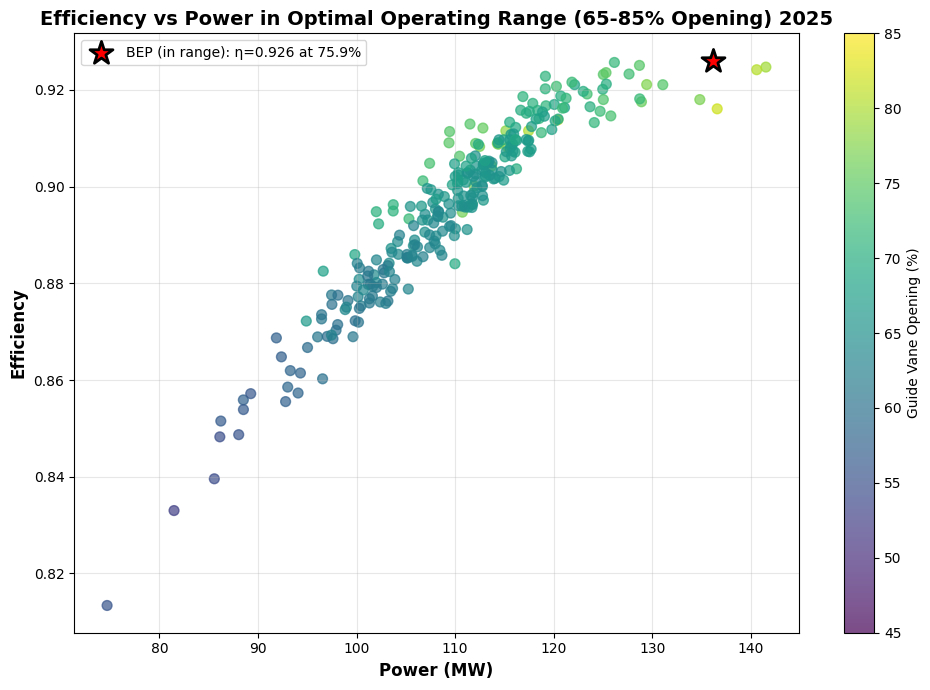

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for the identified optimal operating range (55-85% opening)
df_optimal_range = df_operational[
    (df_operational['Opening'] >= 45) &
    (df_operational['Opening'] <= 85)
].copy()

fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(df_optimal_range['Power'], df_optimal_range['Efficiency'],
                     c=df_optimal_range['Opening'],
                     s=50, alpha=0.7, cmap='viridis',
                     vmin=45, vmax=85)

# Check if BEP falls within this range and plot it
if (bep_data['Opening'] >= 45) and (bep_data['Opening'] <= 85):
    ax.scatter(bep_data['Power'], bep_data['Efficiency'],
               s=300, marker='*', color='red',
               edgecolor='black', linewidth=2,
               label=f'BEP (in range): η={bep_data["Efficiency"]:.3f} at {bep_data["Opening"]:.1f}%')
else:
    # Optionally, plot BEP outside the range if it helps context, or just note it
    print(f"Note: BEP (η={bep_data['Efficiency']:.3f} at {bep_data['Opening']:.1f}% opening) is outside the 70-85% operating range displayed.")

ax.set_xlabel('Power (MW)', fontsize=12, fontweight='bold')
ax.set_ylabel('Efficiency', fontsize=12, fontweight='bold')
ax.set_title('Efficiency vs Power in Optimal Operating Range (65-85% Opening) 2025', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.colorbar(scatter, ax=ax, label='Guide Vane Opening (%)')

plt.tight_layout()
plt.savefig('efficiency_vs_power_optimal_range.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Filter df_operational for the specified Power and Efficiency ranges
df_filtered = df_operational[
    (df_operational['Power'] >= 90) &
    (df_operational['Power'] <= 140) &
    (df_operational['Efficiency'] >= 0.80) &
    (df_operational['Efficiency'] <= 0.98)
].copy()

print(f"Number of data points in filtered range: {len(df_filtered)}")
print(f"Power range in filtered data: {df_filtered['Power'].min():.2f} - {df_filtered['Power'].max():.2f} MW")
print(f"Efficiency range in filtered data: {df_filtered['Efficiency'].min():.3f} - {df_filtered['Efficiency'].max():.3f}")

Number of data points in filtered range: 272
Power range in filtered data: 91.87 - 136.58 MW
Efficiency range in filtered data: 0.856 - 0.926


In [32]:
BIN_WIDTH = 5  # MW (using the same bin width as before)

df_filtered['P_bin'] = (df_filtered['Power'] // BIN_WIDTH) * BIN_WIDTH

envelope_filtered = (
    df_filtered.groupby('P_bin')['Efficiency']
      .agg(
          upper_env=lambda x: np.percentile(x, 95),
          lower_env=lambda x: np.percentile(x, 5),
          median_env='median',
          count='count'
      )
      .reset_index()
)

# Remove weak bins for the filtered data as well
envelope_filtered = envelope_filtered[envelope_filtered['count'] > 30]

print("Filtered Efficiency Envelope calculated.")

Filtered Efficiency Envelope calculated.


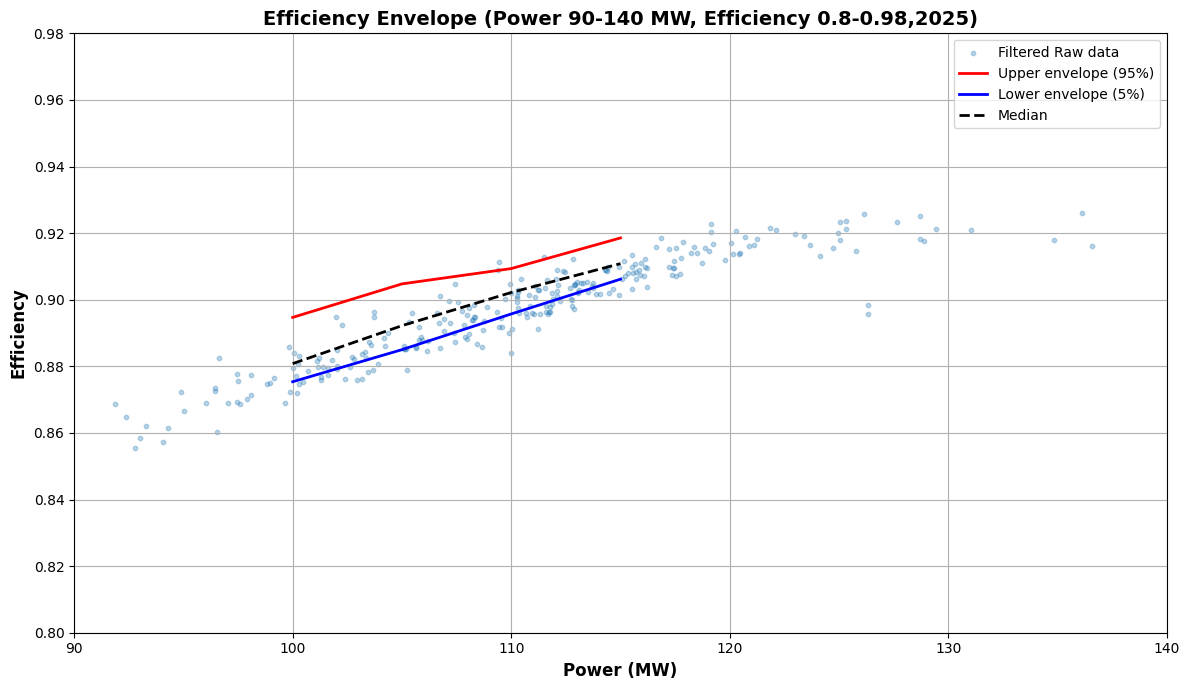

In [33]:
plt.figure(figsize=(12, 7))

plt.scatter(
    df_filtered['Power'],
    df_filtered['Efficiency'],
    s=10,
    alpha=0.3,
    label='Filtered Raw data'
)

plt.plot(
    envelope_filtered['P_bin'],
    envelope_filtered['upper_env'],
    'r-', linewidth=2, label='Upper envelope (95%)'
)

plt.plot(
    envelope_filtered['P_bin'],
    envelope_filtered['lower_env'],
    'b-', linewidth=2, label='Lower envelope (5%)'
)

plt.plot(
    envelope_filtered['P_bin'],
    envelope_filtered['median_env'],
    'k--', linewidth=2, label='Median'
)

plt.xlabel('Power (MW)', fontsize=12, fontweight='bold')
plt.ylabel('Efficiency', fontsize=12, fontweight='bold')
plt.title('Efficiency Envelope (Power 90-140 MW, Efficiency 0.8-0.98,2025)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.xlim(90, 140) # Set x-axis limits to the requested power range
plt.ylim(0.80, 0.98) # Set y-axis limits to the requested efficiency range
plt.tight_layout()
plt.show()

In [34]:
df_2=df_operational.loc[df_operational['Net_Head'].between(81, 89),['Net_Head','Power','Efficiency','Flow']]
df_2

,Net_Head,Power,Efficiency,Flow
345,81.72719,98.84277,0.874566,140.9668
346,81.77719,103.50710,0.887221,145.4244
347,81.70019,111.74400,0.896457,155.5258
348,81.62719,112.35270,0.908752,154.3954
349,81.75519,109.71230,0.900363,151.9335
...,...,...,...,...
799,82.15519,98.97478,0.875077,140.3376
800,82.03319,105.45510,0.895906,146.2671
801,82.07519,97.45089,0.869289,139.2326
802,81.70119,120.27010,0.920749,162.9743
